In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

我们选择标签是关于输入的线性函数。标签同时被均值为0，标准差为0.01高斯噪声破坏。为了使过拟合的效果更加明显，我们可以将问题的维数增加到 d=200 ，并使用一个只包含20个样本的小训练集。

In [ ]:
n_train,n_test,num_input,batch_size =20,100,200,5
true_w,true_b =torch.ones((num_input,1))*0.01,0.05
#利用线性模型生成训练数据集
train_data =d2l.synthetic_data(true_w,true_b,n_train)
train_iter =d2l.load_array(train_data,batch_size)

test_data =d2l.synthetic_data(true_w,true_b,n_test)
test_iter =d2l.load_array(test_data,batch_size,is_train=False)

从0开始实现权重衰减，只需要将L2的平方惩罚添加到原始目标函数中

初始化参数模型

In [3]:
def init_params():
    w =torch.normal(0,1,size=(num_input,1),requires_grad=True)
    b =torch.zeros(1,requires_grad=True)
    return [w,b]

定义L2范数惩罚

In [4]:
def l2_penalty(w):
    return torch.sum(w.pow(2))/2

定义训练代码实现

In [42]:
def train(lambd):
    #这里的lambd和下面的lambd表达式不是一个东西
    w,b=init_params()
    net,loss =lambda X:d2l.linreg(X,w,b),d2l.squared_loss
    num_epochs,lr =100,0.003
    animator =d2l.Animator(xlabel='epochs',ylabel='loss',yscale='log',
                            xlim=[5,num_epochs],legend=['train','test'])

    for epoch in range(num_epochs):
        for X,y in train_iter:
            with torch.enable_grad():
                #增加了L2范数惩罚项，广播机制使L2_penalty(w)成为一个长度为batchsize的向量
                l =loss(net(X),y)+lambd*l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w,b],lr,batch_size)
        
        if (epoch+1)%5 ==0:
            animator.add(epoch+1,(d2l.evaluate_loss(net,train_iter,loss),
                        d2l.evaluate_loss(net,test_iter,loss)))
        
    print('w的l2范数是：',torch.norm(w).item())

忽略正则化直接训练

我们现在用lambd = 0禁用权重衰减后运行这个代码。注意，这里训练误差有了减少，但测试误差没有减少。这意味着出现了严重的过拟合。这是过拟合的一个典型例子。

w的l2范数是： 14.38045883178711


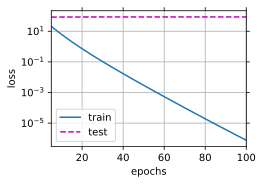

In [43]:
train(lambd=0)

使用权重衰减

下面，我们使用权重衰减来运行代码。注意，在这里训练误差增大，但测试误差减小。这正是我们期望从正则化中得到的效果。

w的l2范数是： 0.37004339694976807


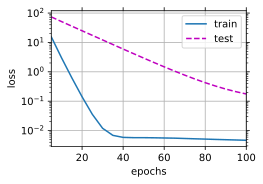

In [44]:
train(lambd=3)

简洁实现

由于权重衰减在神经网络优化中很常用，深度学习框架为了便于使用权重衰减，便将权重衰减集成到优化算法中，以便与任何损失函数结合使用。此外，这种集成还有计算上的好处，允许在不增加任何额外的计算开销的情况下向算法中添加权重衰减。由于更新的权重衰减部分仅依赖于每个参数的当前值，因此优化器必须至少接触每个参数一次。

在下面的代码中，我们在实例化优化器时直接通过weight_decay指定weight decay超参数。默认情况下，PyTorch同时衰减权重和偏移。这里我们只为权重设置了weight_decay，所以bias参数 b 不会衰减。

In [38]:
def train_concise(wd):
    net =nn.Sequential(nn.Linear(num_input,1))

    for param in net.parameters():
        param.data.normal_()
    
    loss =nn.MSELoss()
    num_epochs,lr =100,0.003

    #偏置函数没有衰减
    trainer =torch.optim.SGD([
        {'params':net[0].weight,'weight_decay':wd},
        {'params':net[0].bias}],lr=lr)
    animator =d2l.Animator(xlabel='epochs',ylabel='loss',yscale='log',
                            xlim=[5,num_epochs],legend=['train','test'])
    
    for epoch in range(num_epochs):
        for X,y in train_iter:
            with torch.enable_grad():
                trainer.zero_grad()
                l=loss(net(X),y)#这里的loss内部进行过sum了所以下面不需要sum
            l.backward()
            trainer.step()
        if(epoch+1)%5 ==0:
            animator.add(epoch+1,(d2l.evaluate_loss(net, train_iter, loss),
                                d2l.evaluate_loss(net, test_iter, loss)))
        
    print('w的L2范数：',net[0].weight.norm().item())

这些图看起来和我们从零开始实现权重衰减时的图相同。然而，它们运行得更快，更容易实现，对于更复杂的问题，这一好处将变得更加明显。

w的L2范数： 0.055622607469558716


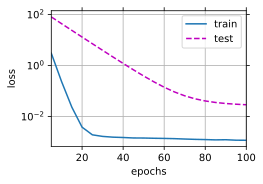

In [39]:
train_concise(5)